# Preparation of the Data


To visualize the embedding it is necessary to reduce the dimension of 1536 to only 2 dimension.


Define if plots should be created


In [53]:
createPlots = False

### Load library's


In [54]:
import numpy as np
import postgres
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib
import random

### Define data structure


In [55]:
class DataPoint:
    def __init__(self, id:int, name:str, page:int, category, vector:np.array):
        self.id = id
        self.name = name
        self.page = page
        self.category = category
        self.vector = vector
        self.x = 0
        self.y = 0
    
    def __str__(self):
        return f"Name: {self.name}\tPage: {self.page}\nCategory: {self.category}\tVector: {self.vector[0:40]}..."
    
class Course:
    def __init__(self, name, x, y, size):
        self.name = name
        self.x = x
        self.y = y
        self.size = size
    
    def __str__(self):
        return f"Name: {self.name}\tX: {self.x}\tY: {self.y}\tSize: {self.size}"


class Document:
    def __init__(self, category, name, x, y, size):
        self.category = category
        self.name = name
        self.x = x
        self.y = y
        self.size = size
    
    def __str__(self):
        return f"Name: {self.name}\nCategory: {self.category}\tX: {self.x}\tY: {self.y}\tSize: {self.size}"

### Loading Data from Database


In [56]:
pg = postgres.PostgresDB()
pg.connect()
response = pg.selectQuery(f"""
                SELECT doc_id, filename, path, doc_segment, embedding_ada002 as vector
                FROM embedding
                JOIN document ON id = doc_id
                --LIMIT 5;""")
pg.disconnect()

In [57]:
data = []

for element in response:
    vector = np.fromstring(element[4][1:-1], dtype=float, sep=',')
    category = element[2].split('/')[1]
    data.append(DataPoint(element[0], element[1], element[3], category, vector))

First 3 entries in `data`:


In [58]:
for i in range(3):
    print(data[i], "\n")

Name: presentation_scrum.pdf	Page: 0
Category: Software Entwicklung 2	Vector: [ 0.00050794  0.00493171  0.00839776 -0.00102744  0.01304558  0.00843738
 -0.007863   -0.01820836 -0.01030575 -0.04433914  0.01381142  0.01037837
  0.01124983 -0.02020217 -0.00192779 -0.02103402  0.01429997 -0.00297916
 -0.00738105  0.00231071 -0.01583163 -0.0026078   0.01422074 -0.01877613
 -0.01465648  0.0098238   0.02136412 -0.00071343  0.00304683 -0.01069527
  0.01852526 -0.00251372 -0.00988322 -0.00144749 -0.01083391 -0.02036062
 -0.01157993  0.00799504  0.02383328  0.00546647]... 

Name: presentation_scrum.pdf	Page: 1
Category: Software Entwicklung 2	Vector: [-0.01785976  0.00471893  0.02113494  0.00518013 -0.00510661  0.01597486
 -0.00943787 -0.0219905  -0.00177796 -0.05162754  0.03128131 -0.0002964
  0.02189692 -0.03593341  0.00350578 -0.02751152  0.01283336  0.00362943
  0.00117723  0.00752623 -0.00408395 -0.00577835  0.01667    -0.02209744
 -0.02658912  0.02363477  0.02461064  0.00566473  0.00750618

In [59]:
matrix = []

for dataPoint in data:
    matrix.append(dataPoint.vector)

matrix = np.array(matrix)

### Reduce Dimensions


In [60]:
tsne = TSNE(n_components=2, perplexity=15, random_state=1, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(13624, 2)

### Visualize Data in a 2D-Plot


Create a list of all courses:


In [61]:
categories = []

for dataPoint in data:
    if categories.count(dataPoint.category) == 0:
        categories.append(dataPoint.category)

Prepare data for visualization:


In [62]:
colormap = plt.get_cmap('jet')

colorDict = {}  # Create an empty dictionary

for i, category in enumerate(categories):
    colorDict[category] = colormap(i / len(categories))

for i, dataPoint in enumerate(data):
    dataPoint.x = vis_dims[i][0]
    dataPoint.y = vis_dims[i][1]

Plot all data points:


In [63]:
if createPlots:
    for i in range(len(data)):
        color = colorDict.get(data[i].category)
        plt.scatter(data[i].x, data[i].y, s=1, color=color, label=data[i].category)
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=5, markerfacecolor=color) for color in colorDict.values()]
    labels = colorDict.keys()
    plt.legend(handles, labels, loc='upper right', fontsize='small', bbox_to_anchor=(1.5, 1.01))
    
    plt.savefig('plot.svg', format='svg', dpi=600)
    plt.savefig('plot.png', format='png', dpi=600)

### Group Courses


In [64]:
courses = []

for dataPoint in data:
    isExisting = False

    for course in courses:
        if dataPoint.category == course.name:
            course.x.append(dataPoint.x)
            course.x.append(dataPoint.x)
            course.size += 1
            isExisting = True

    if not isExisting:
        courses.append(Course(dataPoint.category, [dataPoint.x], [dataPoint.y], 1))

for course in courses:
    course.x = np.array(course.x).mean()
    course.y = np.array(course.y).mean()

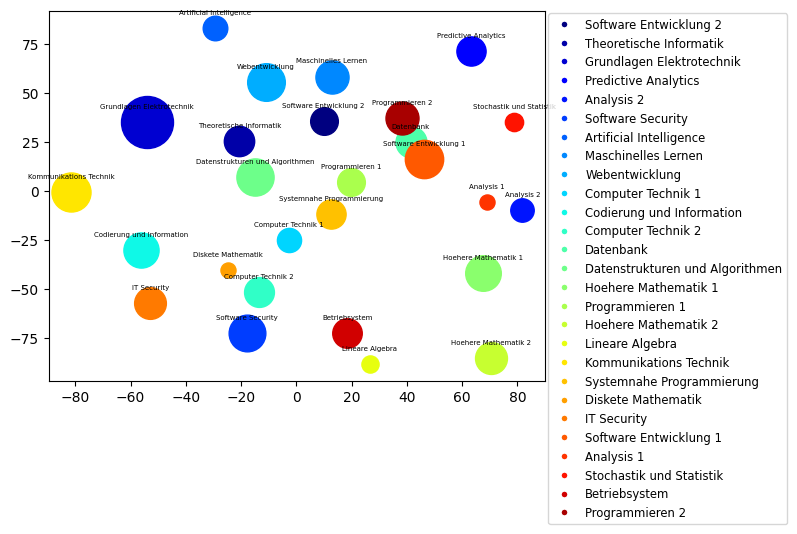

In [65]:
if True:
    for i in range(len(courses)):
        color = colorDict.get(courses[i].name)
        plt.scatter(courses[i].x, courses[i].y, s=courses[i].size/1, color=color, label=courses[i].name)
        plt.annotate(courses[i].name, (courses[i].x, courses[i].y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=5)
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=5, markerfacecolor=color) for color in colorDict.values()]
    labels = colorDict.keys()
    plt.legend(handles, labels, loc='upper right', fontsize='small', bbox_to_anchor=(1.5, 1.01))
    
    plt.savefig('plot.svg', format='svg', dpi=1200)
    plt.savefig('plot.png', format='png', dpi=1200)

### Group Documents


In [66]:
documents = []

for dataPoint in data:
    isExisting = False

    for document in documents:
        if dataPoint.category == document.category and dataPoint.name == document.name:
            document.x.append(dataPoint.x)
            document.x.append(dataPoint.x)
            document.size += 1
            isExisting = True

    if not isExisting:
        documents.append(Document(dataPoint.category, dataPoint.name, [dataPoint.x], [dataPoint.y], 1))

for document in documents:
    document.x = np.array(document.x).mean()
    document.y = np.array(document.y).mean()


print(documents[100])

Name: Skript_Numerik_HM12_Kapitel1-8.pdf
Category: Hoehere Mathematik 1	X: 69.59908294677734	Y: -42.050010681152344	Size: 168


In [67]:
if createPlots:
    for i in range(len(documents)):
        color = colorDict.get(documents[i].category)
        plt.scatter(documents[i].x, documents[i].y, s=documents[i].size, color=color)
        #plt.annotate(documents[i].name, (documents[i].x, documents[i].y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=5)
    
    handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=5, markerfacecolor=color) for color in colorDict.values()]
    labels = colorDict.keys()
    plt.legend(handles, labels, loc='upper right', fontsize='small', bbox_to_anchor=(1.5, 1.01))
    
    plt.savefig('plot.svg', format='svg', dpi=1200)
    plt.savefig('plot.png', format='png', dpi=1200)

### Export to csv


In [68]:
#All Courses
file_name = "allCourses.csv"

with open(file_name, 'w') as file:
    file.write(f"name,x,y,size\n")
    for course in courses:
        file.write(f"{course.name},{course.x},{course.y},{course.size}\n")

file_name = "allDocuments.csv"

with open(file_name, 'w') as file:
    file.write(f"name,category,x,y,size\n")
    for document in documents:
        file.write(f"{document.name},{document.category},{document.x},{document.y},{document.size}\n")

file_name = "allPages.csv"

with open(file_name, 'w') as file:
    file.write(f"name,page,category,x,y\n")
    for dataPoint in data:
        file.write(f"{dataPoint.name},{dataPoint.page},{dataPoint.category},{dataPoint.x},{dataPoint.y}\n")